# MLP, CNN 이해

- MNIST 이미지 인식
- colab에서 실행

# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from keras import layers
from keras import models

# MNIST 데이터

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
train_images.shape

(60000, 28, 28)

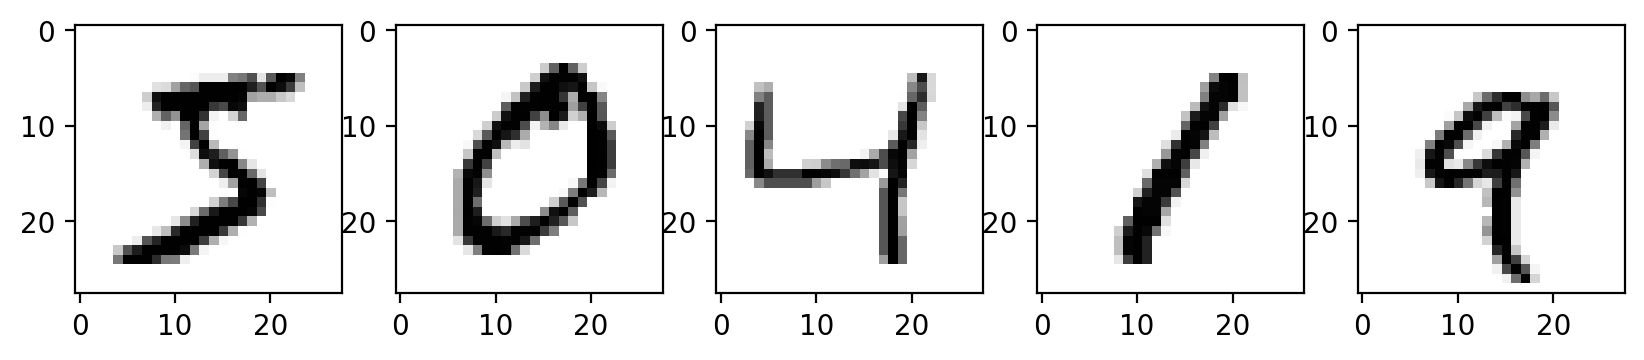

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i in range(5):
    axes[i].imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

In [6]:
train_labels[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

## MLP 입력 전처리
- MLP는 1차원 텐서 즉 벡터만 입력으로 받는다 (일렬 횡대 입력)
- 목적 변수(여기서는 0~9 의 숫자)는 원 핫 인코딩을 해야 하며 케라스가 제공하는 to_categorical를 사용한다 (get_dummies와 같은 역할 수행)
- 입력값은 0~1 사이로 min-max 스케일링은 한다

In [8]:
X_train = train_images.reshape(60000, 28*28)
X_train = X_train.astype('float32')/255

X_test = test_images.reshape(10000, 28*28)
X_test = X_test.astype('float32')/255

y_train_cat = to_categorical(train_labels)
y_test_cat = to_categorical(test_labels)

In [9]:
print(X_train.shape)
y_train_cat[:3]

(60000, 784)


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

# MLP 모델

- [MLP 동작 이해(playground)](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.30687&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)
- [MLP로 구현한 MNIST 인식 모델](https://www.kaggle.com/code/heeraldedhia/mnist-classifier-first-deep-learning-project/notebook)
- 출력단은 10개의 점수를 얻은 후에 소프트맥스를 수행하여 확률을 예측했다 - 10개의 클래스 확률을 얻었다

In [10]:
model_m = models.Sequential()
model_m.add(layers.Dense(100, activation='relu', input_shape = (28*28,)))
model_m.add(layers.Dense(100, activation='relu'))
model_m.add(layers.Dense(10, activation='softmax'))
model_m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


## 조기 종료 조건
- 이포크 종료 조건을 keras.callbacks.EarlyStopping로 설정할 수 있다
- 아래는 총 이포크를 30회 진행하되 이포크가 3회 진행하는 동안 검증 데이터에 대해 정확도가 개선되지 않으면 종료하라는 뜻이다
 - 이 때 검증 데이터는 훈련 데이터중에 20%를 자체적으로 사용한다

In [11]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# adam외에 다른 최적화 알고리즘으로 'rmsprop'도 널리 사용된다
# 레이블은 원 핫 인코딩을 사용해야 한다 (10개의 값을 각각 주어야 하므로)
h = model_m.fit(X_train,
                      y_train_cat,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
2400/2400 [==============================] - 15s 4ms/step - loss: 0.2490 - accuracy: 0.9262 - val_loss: 0.1391 - val_accuracy: 0.9568
Epoch 2/30
2400/2400 [==============================] - 9s 4ms/step - loss: 0.1106 - accuracy: 0.9663 - val_loss: 0.1061 - val_accuracy: 0.9669
Epoch 3/30
2400/2400 [==============================] - 8s 3ms/step - loss: 0.0786 - accuracy: 0.9753 - val_loss: 0.1082 - val_accuracy: 0.9664
Epoch 4/30
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0598 - accuracy: 0.9810 - val_loss: 0.1076 - val_accuracy: 0.9697
Epoch 5/30
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0467 - accuracy: 0.9850 - val_loss: 0.1130 - val_accuracy: 0.9690
Epoch 6/30
2400/2400 [==============================] - 8s 4ms/step - loss: 0.0386 - accuracy: 0.9872 - val_loss: 0.1029 - val_accuracy: 0.9728
Epoch 7/30
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0307 - accuracy: 0.9902 - val_loss: 0.1359 - val_accuracy

## fit 함수
- 매 이포크마다 실행 결과를 history 타입의 객체에 저장한다
- 이 객체에 손실함수와 성능평가 기록이 남아 있다

In [12]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

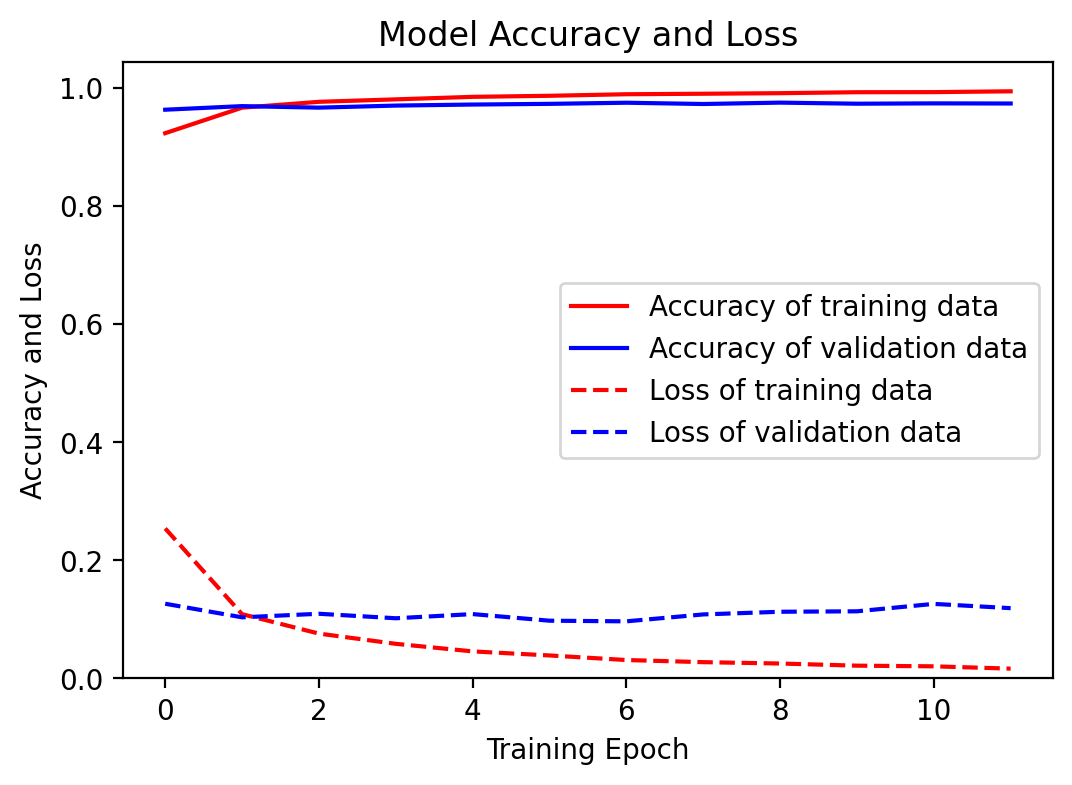

In [ ]:
show_4_graphs(h)

- 검증데이터에 대한 평가는 evaluate()로 수행한다

In [13]:
test_loss, test_acc = model_m.evaluate(X_test, y_test_cat)
print('loss, acc = ',test_loss, test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1119 - accuracy: 0.9769
loss, acc =  0.11190004646778107 0.9768999814987183


###  예측에 사용하기
- predict()함수를 호출하면 클래스 확률을 보여준다
- 10개의 클래스 확률중에 어떤 클래스의 확률이 가장 큰지는 agrmax()로 찾는다

In [14]:
model_m.predict(X_train[0:3])

1/1 [==============================] - 0s 73ms/step


array([[2.0279726e-21, 1.2337124e-07, 1.4977965e-10, 8.4689796e-01,
        4.2683022e-27, 1.5310198e-01, 4.2772780e-22, 1.0290553e-12,
        1.2704614e-16, 2.7816613e-13],
       [9.9999952e-01, 2.2900098e-14, 4.8508542e-07, 1.6107077e-13,
        5.1013639e-16, 3.7178860e-16, 1.7003415e-09, 7.4505614e-14,
        4.8701149e-16, 4.3703834e-12],
       [6.8573109e-16, 2.3181854e-10, 6.1858669e-12, 1.3428507e-10,
        1.0000000e+00, 2.1283812e-11, 3.3198594e-19, 5.6116378e-10,
        1.5028825e-11, 1.0874872e-08]], dtype=float32)

In [15]:
np.argmax(model_m.predict(X_train[0:5]), axis=1)

1/1 [==============================] - 0s 29ms/step


array([3, 0, 4, 1, 9])

# CNN 모델
- CNN은 입력으로 4차원 구조를 필요로 한다
 - (샘플수, 가로, 세로, 특성수)
- 구조를 맞추기 위해서 reshape를 사용한다
- [CNN 모델을 사용한 MNIST 인식](https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9)

In [16]:
X_train_cnn = train_images.reshape(-1,28,28,1)
X_test_cnn = test_images.reshape(-1,28,28,1)

In [17]:
from keras import layers
from keras import models

model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3,3), padding="same", activation='relu', input_shape = (28, 28,1)))
model_cnn.add(layers.MaxPooling2D((2,2)))

model_cnn.add(layers.Conv2D(64, (3,3), padding="same", activation='relu'))
model_cnn.add(layers.MaxPooling2D((2,2)))

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128, activation='relu'))
model_cnn.add(layers.Dense(10, activation='softmax'))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [18]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

model_cnn.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# 다른 최적화 알고리즘 'rmsprop'
# 레이블로 원 핫 인코딩을 사용해야 한다
h = model_cnn.fit(X_train_cnn,
                      y_train_cat,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
2400/2400 [==============================] - 18s 5ms/step - loss: 0.3928 - accuracy: 0.9494 - val_loss: 0.0773 - val_accuracy: 0.9777
Epoch 2/30
2400/2400 [==============================] - 11s 5ms/step - loss: 0.0717 - accuracy: 0.9778 - val_loss: 0.0737 - val_accuracy: 0.9777
Epoch 3/30
2400/2400 [==============================] - 11s 5ms/step - loss: 0.0543 - accuracy: 0.9836 - val_loss: 0.0737 - val_accuracy: 0.9791
Epoch 4/30
2400/2400 [==============================] - 11s 5ms/step - loss: 0.0464 - accuracy: 0.9859 - val_loss: 0.1032 - val_accuracy: 0.9722
Epoch 5/30
2400/2400 [==============================] - 11s 5ms/step - loss: 0.0405 - accuracy: 0.9878 - val_loss: 0.0612 - val_accuracy: 0.9844
Epoch 6/30
2400/2400 [==============================] - 11s 4ms/step - loss: 0.0313 - accuracy: 0.9905 - val_loss: 0.0655 - val_accuracy: 0.9847
Epoch 7/30
2400/2400 [==============================] - 10s 4ms/step - loss: 0.0302 - accuracy: 0.9911 - val_loss: 0.0806 - val_ac

In [19]:
test_loss, test_acc = model_cnn.evaluate(X_test_cnn, y_test_cat)
print('test_acc = ',test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.1103 - accuracy: 0.9831
test_acc =  0.9830999970436096


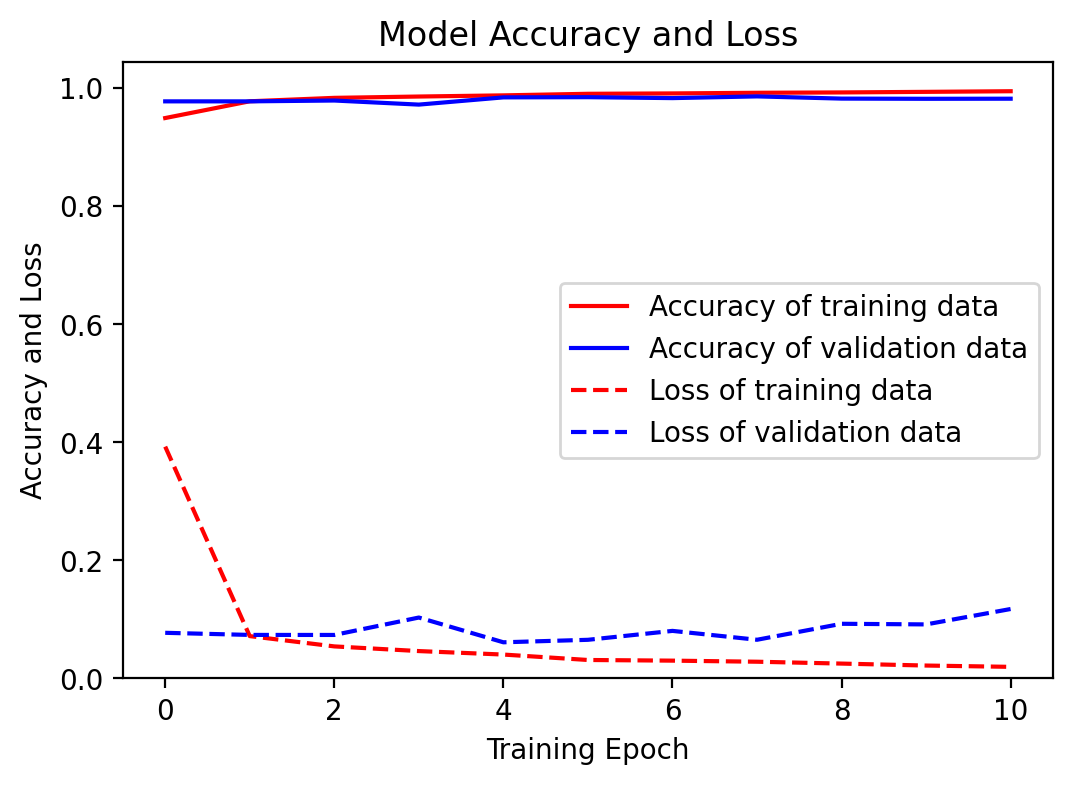

In [20]:
show_4_graphs(h)

# MLP를 이용한  회귀 예측
- 출력단을 다음과 같이 작성하면 회귀예측을 수행하는 모델을 학습한다 (softmax를 호출하면 분류 모델이다)
 - model.add(layers.Dense(1))
- 목적 변수 3개를 예측하는 경우
 - model.add(layers.Dense(3))

# (실습) 성능이 최대한 높게 나오도록 MLP와 CNN 모델을 개선하시오


# (실습) 위에서 얻은 최고 성능의 95%를 달성하는 모델을 만들되 가능하면 간단한 모델, 즉, 파라미터수가 적을 모델을 만드시오